In [2]:
%matplotlib inline

In [17]:
import numpy as np 
from scipy.integrate import odeint
from orbits import elliptic_orbit

import matplotlib as mpl
mpl.rcParams['font.size'] = 18.0

In [18]:
import matplotlib.pyplot as plt

#### Constants etc

In [19]:
km_to_pc = 3.24078e-14 #pc/km
G_N = 4.302e-3*(3.24078e-14)**2 #(pc/M_sun) (pc/s)^2

year = 365.24*24*60*60

kg_to_J = 9e16 #J/kg
Msun_to_kg = 2e30 #kg/Msun
Msun_to_J = Msun_to_kg*kg_to_J #J/Msun

#MW NFW halo properties
rho0 =  1.4e7*1e-9 # Msun pc^-3, see Table 1 in 1304.5127
rs   = 16.1e3      # pc

#NS properties
R_NS = 10*km_to_pc #pc
M_NS = 1.4 #M_sun
vesc_NS = np.sqrt(2*G_N*M_NS/R_NS) #pc/s

#### NS heating

In [126]:
r_list = np.geomspace(1, 50e3, 100)

#DM density profile
x_list = r_list/rs
rho_list = rho0/(x_list*(1+x_list)**2)

#Calculate the orbital period and velocity at each radius
T_orb_list = 0.0*r_list
for i, r in enumerate(r_list):
    orb = elliptic_orbit(a=r, e=0.0)
    T_orb_list[i] = orb.T_orb
v_orb_list = (2*np.pi*r_list)/T_orb_list

#Gravitational focusing factor
focus_factor = (1 + vesc_NS**2/v_orb_list**2)
    
#Maximum rate of DM capture/energy injection
dQdt = rho_list*np.pi*R_NS**2*v_orb_list*focus_factor

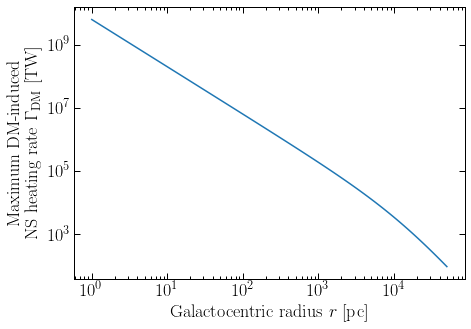

In [127]:
plt.figure(figsize=(7,5))

plt.loglog(r_list, dQdt*Msun_to_J/1e12)

plt.xlabel(r"Galactocentric radius $r$ [pc]")
plt.ylabel("Maximum DM-induced \n NS heating rate $\\Gamma_\\mathrm{DM}$ [TW]")

plt.show()

#### Temperature evolution

Next solve:

$$\frac{\mathrm{d}T}{\mathrm{d}t} = (\Gamma_\mathrm{in} + \Gamma_\mathrm{DM} - \Gamma_\mathrm{emission})/C(T)$$

where
$$ \Gamma_\mathrm{emission} = 4 \pi R_\mathrm{NS}^{2} \sigma_{\mathrm{SB}} T^{4} \epsilon $$

is the energy lost to thermal emission and $\Gamma_\mathrm{in}$ is the internal heat flow from the NS. We'll fix $\Gamma_\mathrm{in}$ by requiring that the internal heat flow is sufficient to maintain equilibrium at an initial temperature of $T_0 = 10^3 \,\mathrm{K}$ in the absence of DM. That is, we fix:

$$\Gamma_\mathrm{in} = 4 \pi R_\mathrm{NS}^{2} \sigma_{\mathrm{SB}} T_0^{4} \epsilon$$

With that, we just solve for the final temperature of the NS (depending on the rate of DM energy injection $\Gamma_\mathrm{DM}$.

We'll fix the emissivity $\epsilon = 10^{-2}$, although that's probably a bit small (making $\epsilon$ bigger just lowers the final temperature achieved by the NS). Finally, we assume the heat capacity of the NS as:

$$ C(T) = 10^{31} \left(\frac{T}{10^8 \,\mathrm{K}}\right) \,\mathrm{J/K}$$

(see e.g. https://www.int.washington.edu/talks/WorkShops/int_16_2b/People/Reddy_S/Reddy.pdf).

In [128]:
T0 = 1e3
sig_B =  5.67e-8 #W/m^2/K^4

def dTdt_NS(T, t, Gamma_DM=1e12):
    epsilon = 1e-2
    Gamma_in = epsilon*4*np.pi*(1e4)**2*sig_B*(T0)**4 #J/s
    Gamma_em = epsilon*4*np.pi*(1e4)**2*sig_B*(T)**4 #J/s
    #print(Gamma_em/1e12)
    C = 1e31*(T/1e8) #J/K
    return (Gamma_in + Gamma_DM - Gamma_em)/C

In [129]:
t_list = np.geomspace(1, 13e9, 10000)
def calcT_final(Gamma_DM):
    res = odeint(dTdt_NS, T0, t_list*year, args=(Gamma_DM,))
    return res[-1,0] #Return the final temperature

In [130]:
T_list = 0.0*r_list
T_list_1pc = 0.0*r_list
T_list_tiny = 0.0*r_list
for i, Gamma in enumerate(dQdt*Msun_to_J):
    T_list[i] = calcT_final(Gamma)
    T_list_1pc[i] = calcT_final(Gamma*1e-2)
    T_list_tiny[i] = calcT_final(Gamma*1e-6)

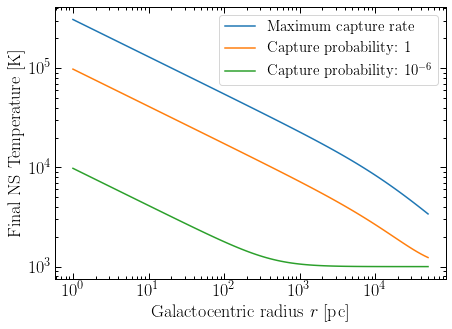

In [131]:
plt.figure(figsize=(7,5))

plt.loglog(r_list, T_list, label="Maximum capture rate")
plt.loglog(r_list, T_list_1pc, label=r"Capture probability: 1%")
plt.loglog(r_list, T_list_tiny, label=r"Capture probability: $10^{-6}$")

plt.xlabel(r"Galactocentric radius $r$ [pc]")
plt.ylabel(r"Final NS Temperature [K]")

plt.legend()

plt.show()